# 1 Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

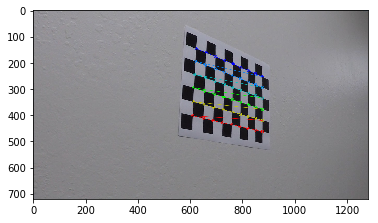

In [2]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), ..., (8,5,0)
# Calibration image has chessboard size as 9*6
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Iterate each image
for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    # plt.imshow(img)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chaessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # print(ret)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Store the data of calibration
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./pickled_data/calibration_data.p', 'wb'))

# 2 Distortion Correction

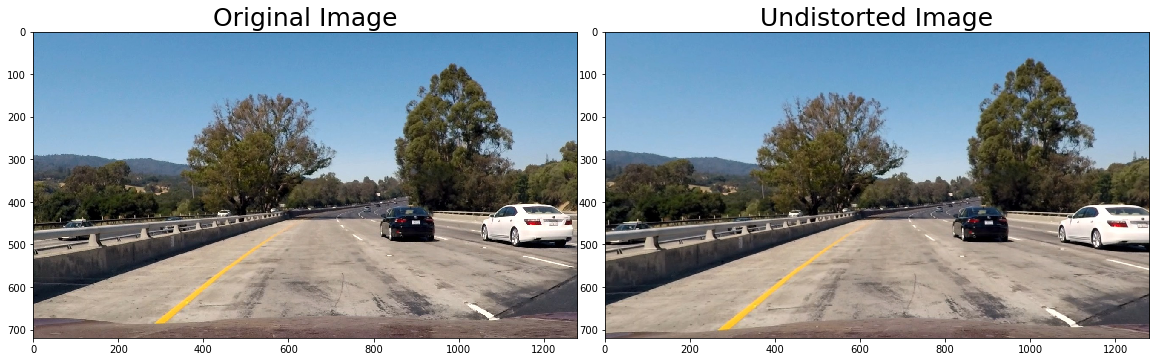

In [4]:
# Loading camera calibration
calibration_data = pickle.load( open('./pickled_data/calibration_data.p', 'rb' ) )
mtx, dist = map(calibration_data.get, ('mtx', 'dist'))

# Read in and make a list of test images
test_images = glob.glob('./test_images/test*.jpg')

def undistort(img, mtx=mtx, dist=dist):
    image = cv2.undistort(img, mtx, dist, None, mtx)
    return image

test_img = mpimg.imread(test_images[0])
test_img_undistort = undistort(test_img)

# Visualize undistorted image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_undistort)
ax2.set_title('Undistorted Image', fontsize=25)

# 3 Color/Gradient Threshold

### 3.1 Color Threshold

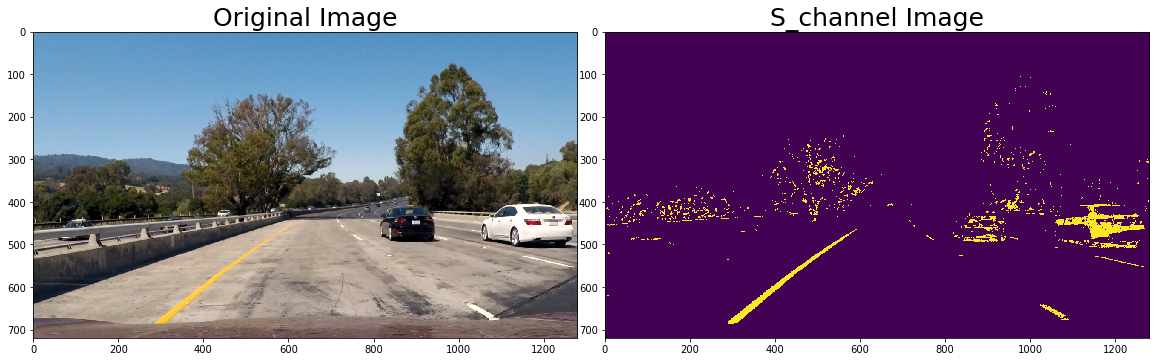

In [5]:
# Define a function that thresholds the S-channel of HLS
def hls(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Visualize undistorted image

# test_img = mpimg.imread(test_images[1])
test_img_hls = hls(test_img, (150,255))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_hls)
ax2.set_title('S_channel Image', fontsize=25)

### 3.2 Gradient Threshold

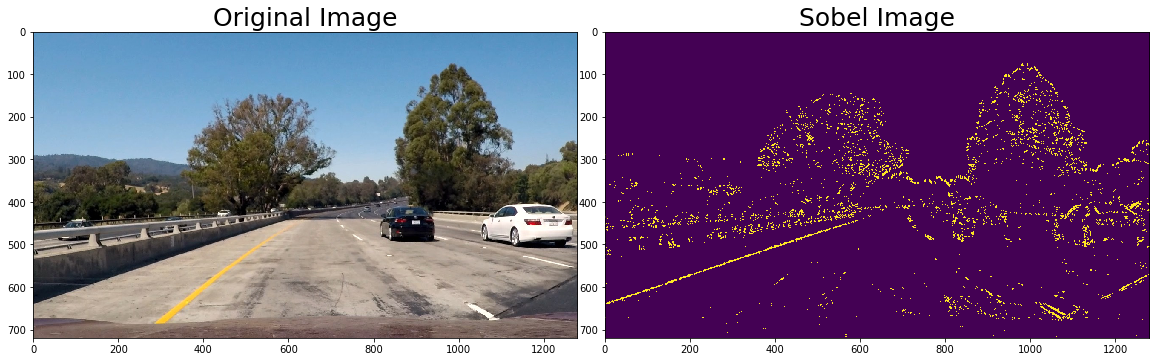

In [6]:
def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary

# Apply each of the thresholding functions
def combine_thresh(img, kernel=3, s_thresh=(0,255), m_thresh=(0,255), d_thresh=(0, np.pi/2)):
    gradx = sobel_thresh(img, 'x', kernel, s_thresh)
    grady = sobel_thresh(img, 'y', kernel, s_thresh)
    mag_binary = mag_thresh(img, kernel, m_thresh)
    dir_binary = dir_thresh(img, kernel, d_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Visualize undistorted image

# test_img = mpimg.imread(test_images[1])
test_img_combine = combine_thresh(test_img, ksize, (30,160), (30,160), (0.8, 1.2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_combine)
ax2.set_title('Sobel Image', fontsize=25)

### 3.3 Combine Color and Gradient

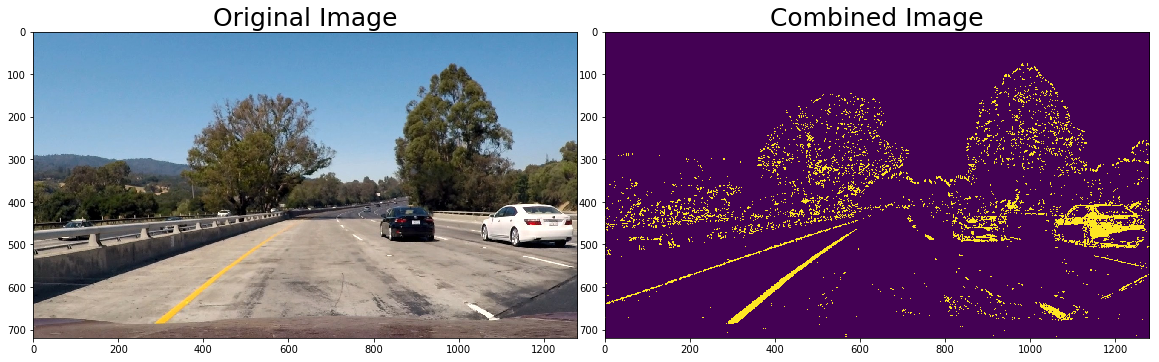

In [7]:
# test_img = mpimg.imread(test_images[0])

test_img_hls = hls(test_img, (150,255))
test_img_combine = combine_thresh(test_img, ksize, (30,160), (30,160), (0.8, 1.2))

test_img_cg = np.zeros_like(test_img_hls)
test_img_cg[(test_img_hls == 1) | (test_img_combine == 1)] = 1

# Visualize undistorted image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_cg)
ax2.set_title('Combined Image', fontsize=25)

# 4 Perspective Transform

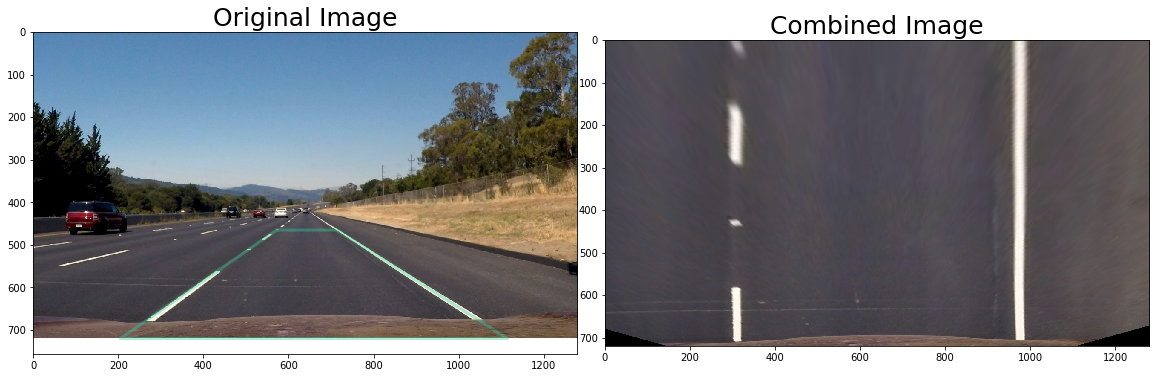

In [8]:
def unwarp(img, src, dst):
    h, w = (img.shape[0], img.shape[1])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return (unwarped, M, Minv)

# test_img = mpimg.imread(test_images[0])
test_img2 = mpimg.imread('./test_images/straight_lines2.jpg')
test_img_undistort2 = undistort(test_img2)

h, w = (test_img2.shape[0], test_img2.shape[1])
offset = 300

src = np.float32([ 
    [572, 465],
    [714, 465],
    [1115, 720],
    [205, 720]
])

dst = np.float32([
    [offset, 0],
    [w-offset, 0],
    [w-offset, h], 
    [offset, h]
])

test_img_unwarp2 = unwarp(test_img_undistort2, src, dst)[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img2)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(test_img_unwarp2)
ax2.set_title('Combined Image', fontsize=25)

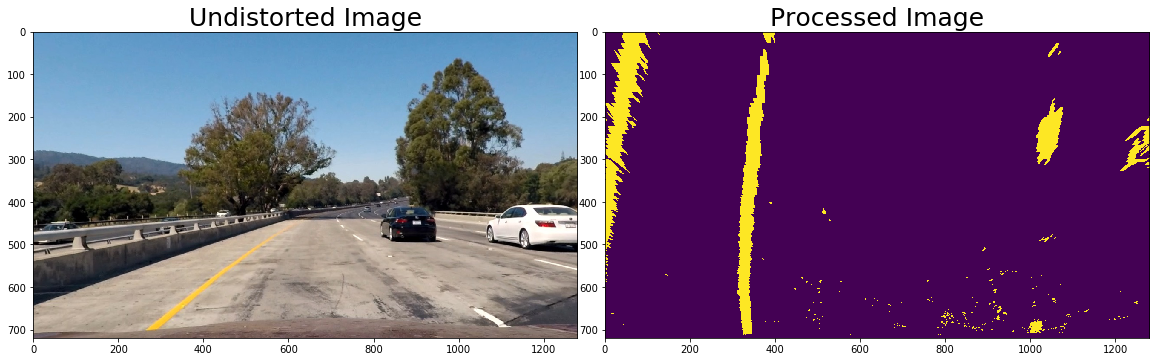

In [9]:
# test_img = mpimg.imread(test_images[0])

test_img_undistort = undistort(test_img)
test_img_hls = hls(test_img_undistort, (150,255))
test_img_combine = combine_thresh(test_img_undistort, ksize, (30,160), (30,160), (0.8, 1.2))

test_img_cg = np.zeros_like(test_img_hls)
test_img_cg[(test_img_hls == 1) | (test_img_combine == 1)] = 1

binary_warped = unwarp(test_img_cg, src, dst)[0]

# Visualize undistorted image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
ax1.imshow(test_img_undistort)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(binary_warped)
ax2.set_title('Processed Image', fontsize=25)

# 5 Detect Lane Lines

6


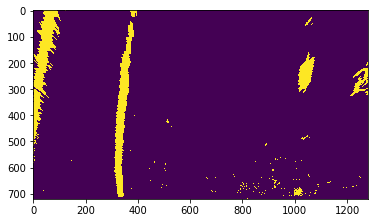

In [10]:
test_images = glob.glob('./test_images/test*.jpg')
test_images_processed = []

def origin_to_process(img):
    
    image_undistort = undistort(img)
    image_hls = hls(image_undistort, (150,255))
    image_combine = combine_thresh(image_undistort, ksize, (30,160), (30,160), (0.8, 1.2))

    image_cg = np.zeros_like(image_hls)
    image_cg[(image_hls == 1) | (image_combine == 1)] = 1

    binary_warped = unwarp(image_cg, src, dst)[0]
    Minv = unwarp(image_cg, src, dst)[2]
    
    return (binary_warped, Minv)

for img in test_images:
    image = mpimg.imread(img)
    
    origin_to_process(image)
    test_images_processed.append(binary_warped)
    
plt.imshow(test_images_processed[2])
print(len(test_images_processed))

In [36]:
def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = origin_to_process(image)[0]
    Minv = origin_to_process(image)[1]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy, Minv)

(720, 0)

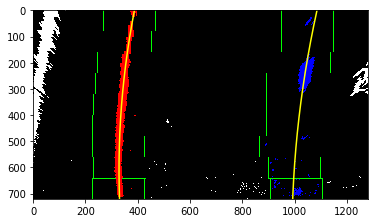

In [12]:
image_example = test_images_processed[0]
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLanes(image_example)

# Generate x and y values for plotting
ploty = np.linspace(0, image_example.shape[0]-1, image_example.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 6 Determine the Lane Curvature

In [15]:
yRange = 719
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

def drawLine(img, left_fit, right_fit, Minv):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _, Minv = findLines(img)
    output = drawLine(img, left_fit, right_fit, Minv)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

In [45]:
def pipeline(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _, Minv = findLines(img)
    output = drawLine(img, left_fit, right_fit, Minv)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    fontScale=2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

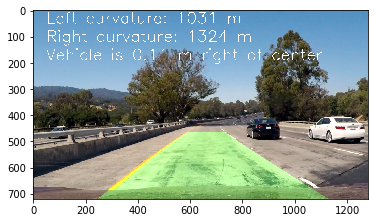

In [46]:
img_example = mpimg.imread('test_images/test1.jpg')
plt.imshow(pipeline(img_example))

# 7 Video

In [29]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _, Minv = findLines(img)
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, Minv)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, Minv):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit, Minv)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, Minv = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle, Minv)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:01<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

